In [1]:
%pip install pandas
%pip install opencv-python
%pip install matplotlib
%pip install nbformat
%pip install plotly


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import os

In [3]:
header_names = [
    "image_name",
    "face_id_in_image",
    "face_box_top",
    "face_box_left",
    "face_box_right",
    "face_box_bottom",
    "face_box_confidence",
    "expression_label",
]
label_df = pd.read_csv(
    "../../data/raw/expw/label/label.csv",
    names=header_names,
    delimiter=" ",
    index_col=False,
)

label_df.head()

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_confidence,expression_label
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0


In [4]:
expression_labels = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral",
}

In [5]:
for index, row in label_df.iterrows():
    label_df.loc[index, "expression_label"] = expression_labels.get(
        row["expression_label"]
    )

label_df["expression_label"] = label_df["expression_label"].astype("category")

label_df["expression_label"].head()

C:\Users\pedro\AppData\Local\Temp\ipykernel_32280\3108122209.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'angry' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  label_df.loc[index, "expression_label"] = expression_labels.get(


0    angry
1    angry
2     fear
3    happy
4    angry
Name: expression_label, dtype: category
Categories (7, object): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Create samples for analyzing quality of data


In [6]:
sample_total = label_df.sample(30, random_state=42)
sample_total.head()

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_confidence,expression_label
69877,awe_old_487.jpg,0,439,405,540,574,67.7653,happy
2362,angry_old_5.jpg,0,22,44,178,156,63.6562,angry
66076,awe_boss_491.jpg,1,23,0,95,118,27.8661,happy
22899,fierce_president_685.jpg,0,75,245,471,301,55.7798,neutral
67429,awe_family_430.jpg,0,224,593,689,320,30.0094,happy


In [7]:
img_folder_path = "../../data/raw/expw/img/"
margin = 0.1

In [8]:
sample_total_images = []
for index, row in sample_total.iterrows():
    img = cv2.imread(img_folder_path + row["image_name"])

    facebox_right = row["face_box_right"]
    facebox_left = row["face_box_left"]
    facebox_bottom = row["face_box_bottom"]
    facebox_top = row["face_box_top"]

    width_margin = int((facebox_right - facebox_left) * margin)
    height_margin = int((facebox_bottom - facebox_top) * margin)

    adjusted_top = max(facebox_top - height_margin, 0)
    adjusted_bottom = min(facebox_bottom + height_margin, img.shape[0])
    adjusted_left = max(facebox_left - width_margin, 0)
    adjusted_right = min(facebox_right + width_margin, img.shape[1])

    cv2.rectangle(
        img,
        (adjusted_left, adjusted_top),
        (adjusted_right, adjusted_bottom),
        (0, 0, 255),
        2,
    )
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sample_total_images.append(image_rgb)

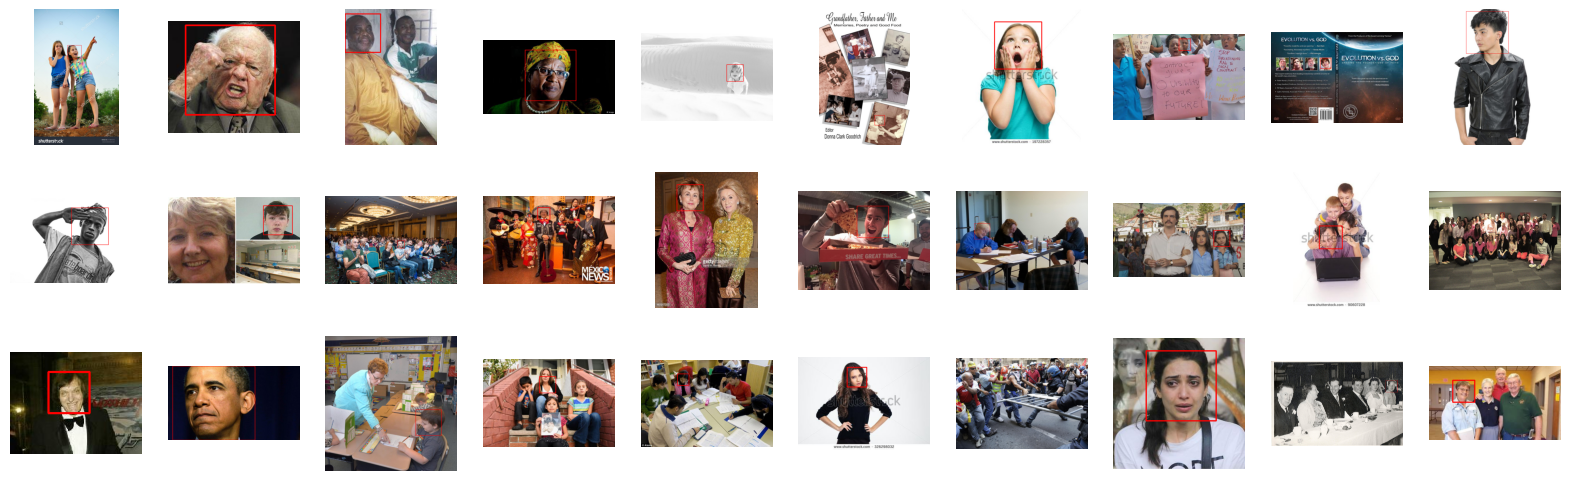

In [9]:
fig, ax = plt.subplots(3, 10, figsize=(20, 6))
for idx in range(len(sample_total_images)):
    img = sample_total_images[idx]
    row, col = divmod(idx, 10)
    ax[row, col].imshow(img, cmap="gray")
    ax[row, col].axis("off")  

plt.show()

In [10]:
low_confidence_df = label_df[label_df.face_box_confidence < 50.0]
low_confidence_df.head()

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_confidence,expression_label
0,angry_actor_104.jpg,0,28,113,226,141,22.93620,angry
2,angry_actor_120.jpg,1,53,53,372,372,13.94340,fear
6,angry_actor_139.jpg,0,0,0,1127,1127,33.52480,angry
7,angry_actor_14.jpg,0,13,120,200,93,39.75540,angry
8,angry_actor_147.jpg,1,119,47,142,214,8.79739,neutral


In [11]:
high_confidence_df = label_df[label_df.face_box_confidence >= 50.0]
high_confidence_df.head()

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_confidence,expression_label
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,angry
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,happy
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,angry
5,angry_actor_137.jpg,0,93,468,842,467,88.9519,angry
9,angry_actor_150.jpg,0,56,263,376,169,81.8792,angry


In [12]:
low_confidence_sample_df = low_confidence_df.sample(30, random_state=42)
high_confidence_sample_df = high_confidence_df.sample(30, random_state=42)

In [13]:
low_confidence_images = []
low_confidence_image_emotions = []
for index, row in low_confidence_sample_df.iterrows():
    img = cv2.imread(img_folder_path + row["image_name"])

    facebox_right = row["face_box_right"]
    facebox_left = row["face_box_left"]
    facebox_bottom = row["face_box_bottom"]
    facebox_top = row["face_box_top"]

    width_margin = int((facebox_right - facebox_left) * margin)
    height_margin = int((facebox_bottom - facebox_top) * margin)

    adjusted_top = max(facebox_top - height_margin, 0)
    adjusted_bottom = min(facebox_bottom + height_margin, img.shape[0])
    adjusted_left = max(facebox_left - width_margin, 0)
    adjusted_right = min(facebox_right + width_margin, img.shape[1])
   
   

    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    cropped_img_with_margin = image_rgb[
        adjusted_top:adjusted_bottom, adjusted_left:adjusted_right
    ]

    low_confidence_images.append(cropped_img_with_margin)
    low_confidence_image_emotions.append(
        row["expression_label"]
    )

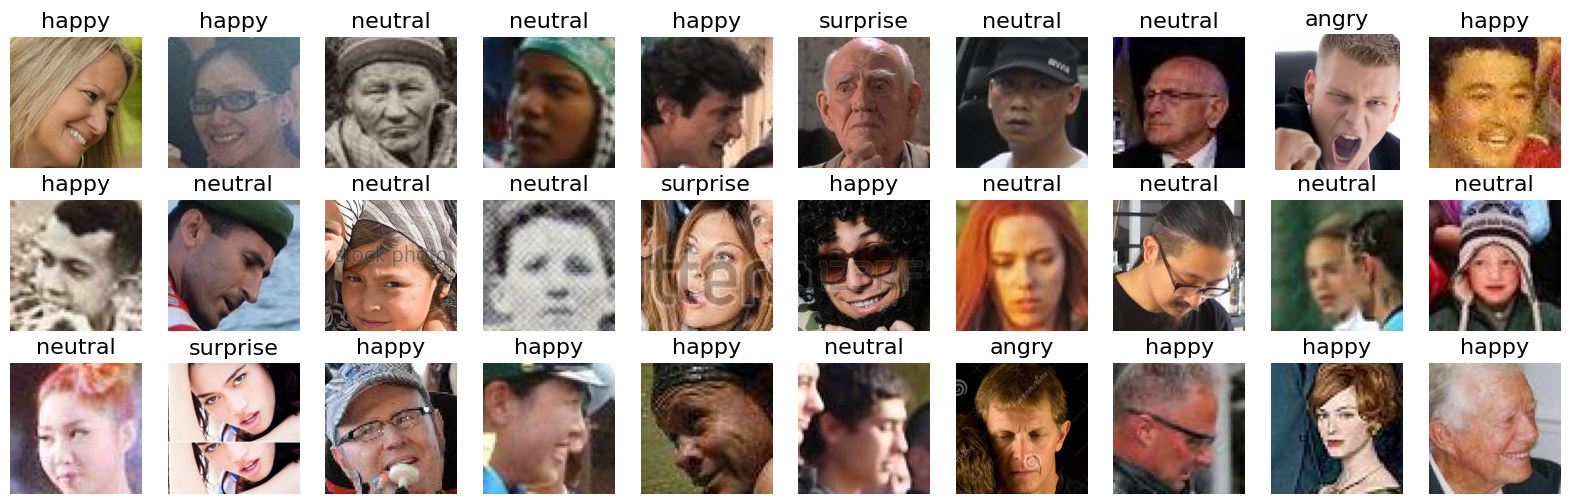

In [14]:
fig, ax = plt.subplots(3, 10, figsize=(20, 6))
for idx in range(len(low_confidence_images)):
    img = low_confidence_images[idx]
    emotion = low_confidence_image_emotions[idx]
    row, col = divmod(idx, 10)
    ax[row, col].imshow(img, cmap="gray")
    ax[row, col].axis("off")
    ax[row, col].set_title(emotion, fontsize=16)   

plt.show()

In [15]:
high_confidence_images = []
high_confidence_image_emotions = []
for index, row in high_confidence_sample_df.iterrows():
    img = cv2.imread(img_folder_path + row["image_name"])

    facebox_right = row["face_box_right"]
    facebox_left = row["face_box_left"]
    facebox_bottom = row["face_box_bottom"]
    facebox_top = row["face_box_top"]

    width_margin = int((facebox_right - facebox_left) * margin)
    height_margin = int((facebox_bottom - facebox_top) * margin)

    adjusted_top = max(facebox_top - height_margin, 0)
    adjusted_bottom = min(facebox_bottom + height_margin, img.shape[0])
    adjusted_left = max(facebox_left - width_margin, 0)
    adjusted_right = min(facebox_right + width_margin, img.shape[1])

   
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cropped_img_with_margin = image_rgb[
        adjusted_top:adjusted_bottom, adjusted_left:adjusted_right
    ]

    high_confidence_images.append(cropped_img_with_margin)

    high_confidence_image_emotions.append(
        row["expression_label"]
    )

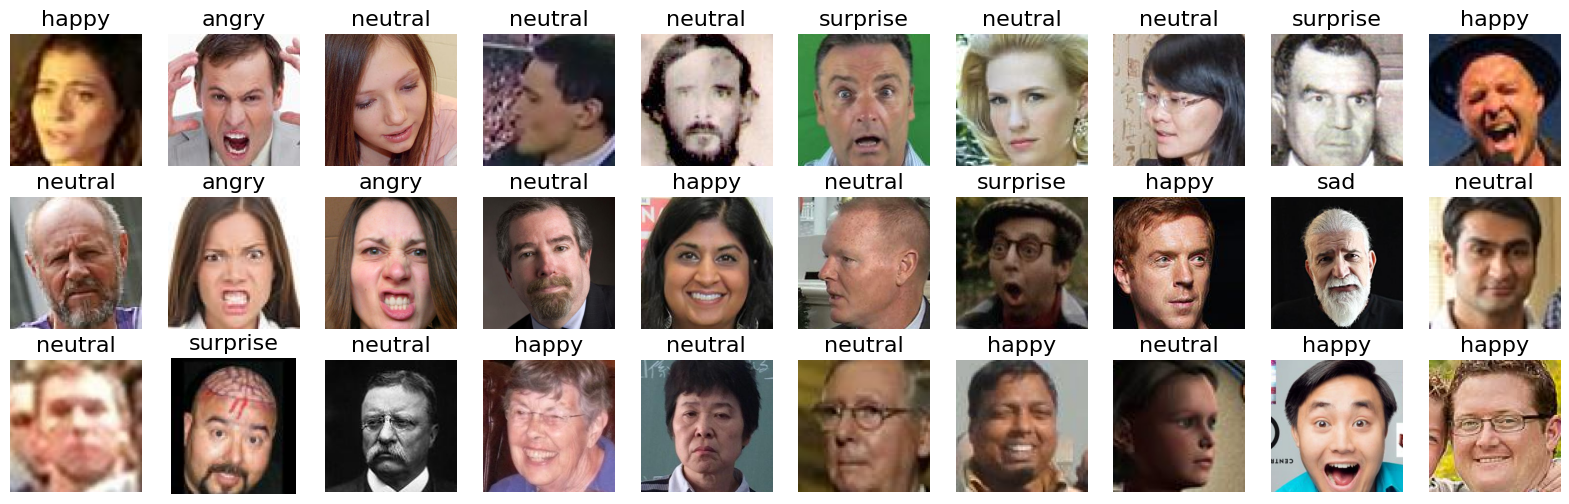

In [16]:
fig, ax = plt.subplots(3, 10, figsize=(20, 6))
for idx in range(len(high_confidence_images)):
    img = high_confidence_images[idx]
    emotion = high_confidence_image_emotions[idx]
    row, col = divmod(idx, 10)
    ax[row, col].imshow(img, cmap="gray")
    ax[row, col].axis("off")
    ax[row, col].set_title(emotion, fontsize=16)   

plt.show()

# Check distribution of data


In [17]:
grouped_all_count = label_df.groupby(["expression_label"])["expression_label"].count()

grouped_all_count

C:\Users\pedro\AppData\Local\Temp\ipykernel_32280\576890491.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_all_count = label_df.groupby(["expression_label"])["expression_label"].count()


expression_label
angry        3671
disgust      3995
fear         1088
happy       30537
neutral     34883
sad         10559
surprise     7060
Name: expression_label, dtype: int64

In [22]:
fig = px.bar(
    x=grouped_all_count.index, y=grouped_all_count.values, color=grouped_all_count.index
)

fig.update_layout(
    title="Total images for each label in Expressions-in-the-Wild dataset",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
    font_size=16
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()